This notebook takes borehole data from the East Kimberley and depth to base of cenozoic interporetations and finds what the key data for predicting them may be

Neil Symington
neil.symington@ga.gov.au

In [1]:
%matplotlib inline

In [2]:
from sqlite3 import dbapi2 as sqlite
from shapely.geometry import Polygon
import pandas as pd
import fiona
import numpy as np
from hydrogeol_utils import spatial_functions, AEM_utils, plotting_utils, borehole_utils
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
import matplotlib.pyplot as plt
import os
import sqlalchemy as db
from sqlalchemy import create_engine, event
import netCDF4
import yaml
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def search(kword_dict, word):
    """
    A search function for finding if a keword
    exists as a list element within a dictionary entry
    
    @param kword_dict: dictionary with keywords
    @word: string
    returns
    the key for the entry if it exists or None if not
    """
    word = word.lower()
    for k in kword_dict:
        for v in kword_dict[k]:
            if word in v:
                return k
    return None

# Function for assigning stratigraphy above and below a point
# for a given downhole log/ layered model
def assign_stratigraphy_from_depth(df, depth, depth_columns, labels = ['cenozoic', 'mixed_signal', 'basement']):
    
    df['stratigraphy'] = ''
    
    if depth_columns == ['Depth']:
        
        for index, row in df.iterrows():
            if row['Depth'] < depth:
                df.at[index, 'stratigraphy'] = labels[0]
            elif row['Depth'] == depth:
                df.at[index, 'stratigraphy'] = labels[1]
            elif row['Depth'] > depth:
                df.at[index, 'stratigraphy'] = labels[2]
        return df
    
    elif depth_columns == ['Depth_from', 'Depth_to']:
        for index, row in df.iterrows():
            if row['Depth_to'] < depth:
                df.at[index, 'stratigraphy'] = labels[0]
            elif (row['Depth_from'] < depth) & (row['Depth_to'] > depth):
                df.at[index, 'stratigraphy'] = labels[1]
            elif row['Depth_from'] > depth:
                df.at[index, 'stratigraphy'] = labels[2]
        return df


In [4]:
# Extract data from the database

path = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\spatialite"

DB_PATH = os.path.join(path, "East_Kimberley_borehole_data.sqlite")

SPATIALITE_PATH = r'C:\mod_spatialite-4.3.0a-win-amd64'

# Add spatialite dll to path
os.environ['PATH'] = SPATIALITE_PATH + ';' + os.environ['PATH']

engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)

@event.listens_for(engine, 'connect')
def connect(dbapi_connection, connection_rec):
    dbapi_connection.enable_load_extension(True)
    dbapi_connection.execute('SELECT load_extension("mod_spatialite")')


connection = engine.connect()


In [17]:
# No lets import the interpreted depths

# Bring in the interpreted depth to the base of the ceonozoic
infile = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\stratigraphy\base_of_cenozoic_picked.csv"

df_interp = pd.read_csv(infile)

enos = df_interp['borehole_id'].unique()

In [18]:
df_header = borehole_utils.extract_sql_with_primary_key("borehole", ['*'], connection, enos,
                                                verbose = True)

df_interp = df_interp.merge(df_header, on = 'borehole_id')

# Now join the coordinates onto the new dataframe

df_interp = df_interp[['borehole_id','base_of_cenozoic_depth','base_of_ceno_elevation','Easting', 'Northing']]


select t.* from borehole t where t.borehole_id in (635728,635921,635730,635733,635734,635735,635737,635738,635739,635740,635741,635742,635744,635747,635748,635749,635746);


In [19]:
df_header

,borehole_id,Borehole_name,Alternative_name,Easting,Northing,Ground_elevation_mAHD,Induction_acquired,Gamma_acquired,Javelin_acquired,Hylogger_acquired_on_core,Hylogger_acquired_on_chips,Lithology_available,EC_pH_acquired,SWL_available,Construction_available,MagSus_available,AEM_conductivity_available,geometry,geom
0,635728,RN040873,KR08,520144.760,8306293.880,7.519,1,1,1,1,0,1,1,1,1,1,1,POINT (520144.76 8306293.88),b'\x00\x01\xc0n\x00\x00\xa4p=\nC\xbf\x1fA\x85\...
1,635730,RN040880,KR22a,523640.009,8316422.357,4.364,1,1,1,1,0,1,1,1,1,1,1,POINT (523640.009 8316422.357),b'\x00\x01\xc0n\x00\x00\xc7K7\t\xe0\xf5\x1fA\x...
2,635733,RN040874,KR30,501830.614,8295403.070,17.506,1,1,1,1,0,1,1,1,1,1,1,POINT (501830.614 8295403.07),b'\x00\x01\xc0n\x00\x00\x7fj\xbct\x1a\xa1\x1eA...
3,635734,RN040877,KR31,504915.931,8292360.686,17.913,1,0,1,1,0,1,1,1,1,1,1,POINT (504915.931 8292360.686),b'\x00\x01\xc0n\x00\x00b\x10X\xb9O\xd1\x1eA\x8...
4,635735,RN040878,KR33,505309.448,8293856.701,16.494,1,1,1,1,0,1,1,1,1,1,1,POINT (505309.448 8293856.701),b'\x00\x01\xc0n\x00\x00\x12\x83\xc0\xcau\xd7\x...
5,635737,RN040884,KR38,507769.229,8299897.749,12.462,1,1,1,1,0,1,1,1,1,1,1,POINT (507769.229 8299897.749),b'\x00\x01\xc0n\x00\x00\xdb\xf9~\xea\xe4\xfd\x...
6,635738,RN040883,KR40,514309.962,8298828.237,17.673,1,1,1,1,0,1,1,1,1,1,1,POINT (514309.962 8298828.237),b'\x00\x01\xc0n\x00\x00+\x87\x16\xd9\x17d\x1fA...
7,635739,RN040881,KR45,500051.985,8295681.132,18.799,1,1,1,1,0,1,1,1,1,1,1,POINT (500051.985 8295681.132),b'\x00\x01\xc0n\x00\x00\n\xd7\xa3\xf0O\x85\x1e...
8,635740,RN040882,KR46,500053.109,8296644.456,18.357,1,1,1,1,0,1,1,1,1,1,1,POINT (500053.109 8296644.456),b'\x00\x01\xc0n\x00\x00-\xb2\x9doT\x85\x1eA\xa...
9,635741,RN040876,KR48,500049.774,8295302.212,19.046,1,1,1,1,0,1,1,1,1,1,1,POINT (500049.774 8295302.212),b'\x00\x01\xc0n\x00\x00\xbct\x93\x18G\x85\x1eA...


utm_zone = 52
17 points in UTM bounding box: [432985.0, 8287369.0, 542730.465, 8331303.544]


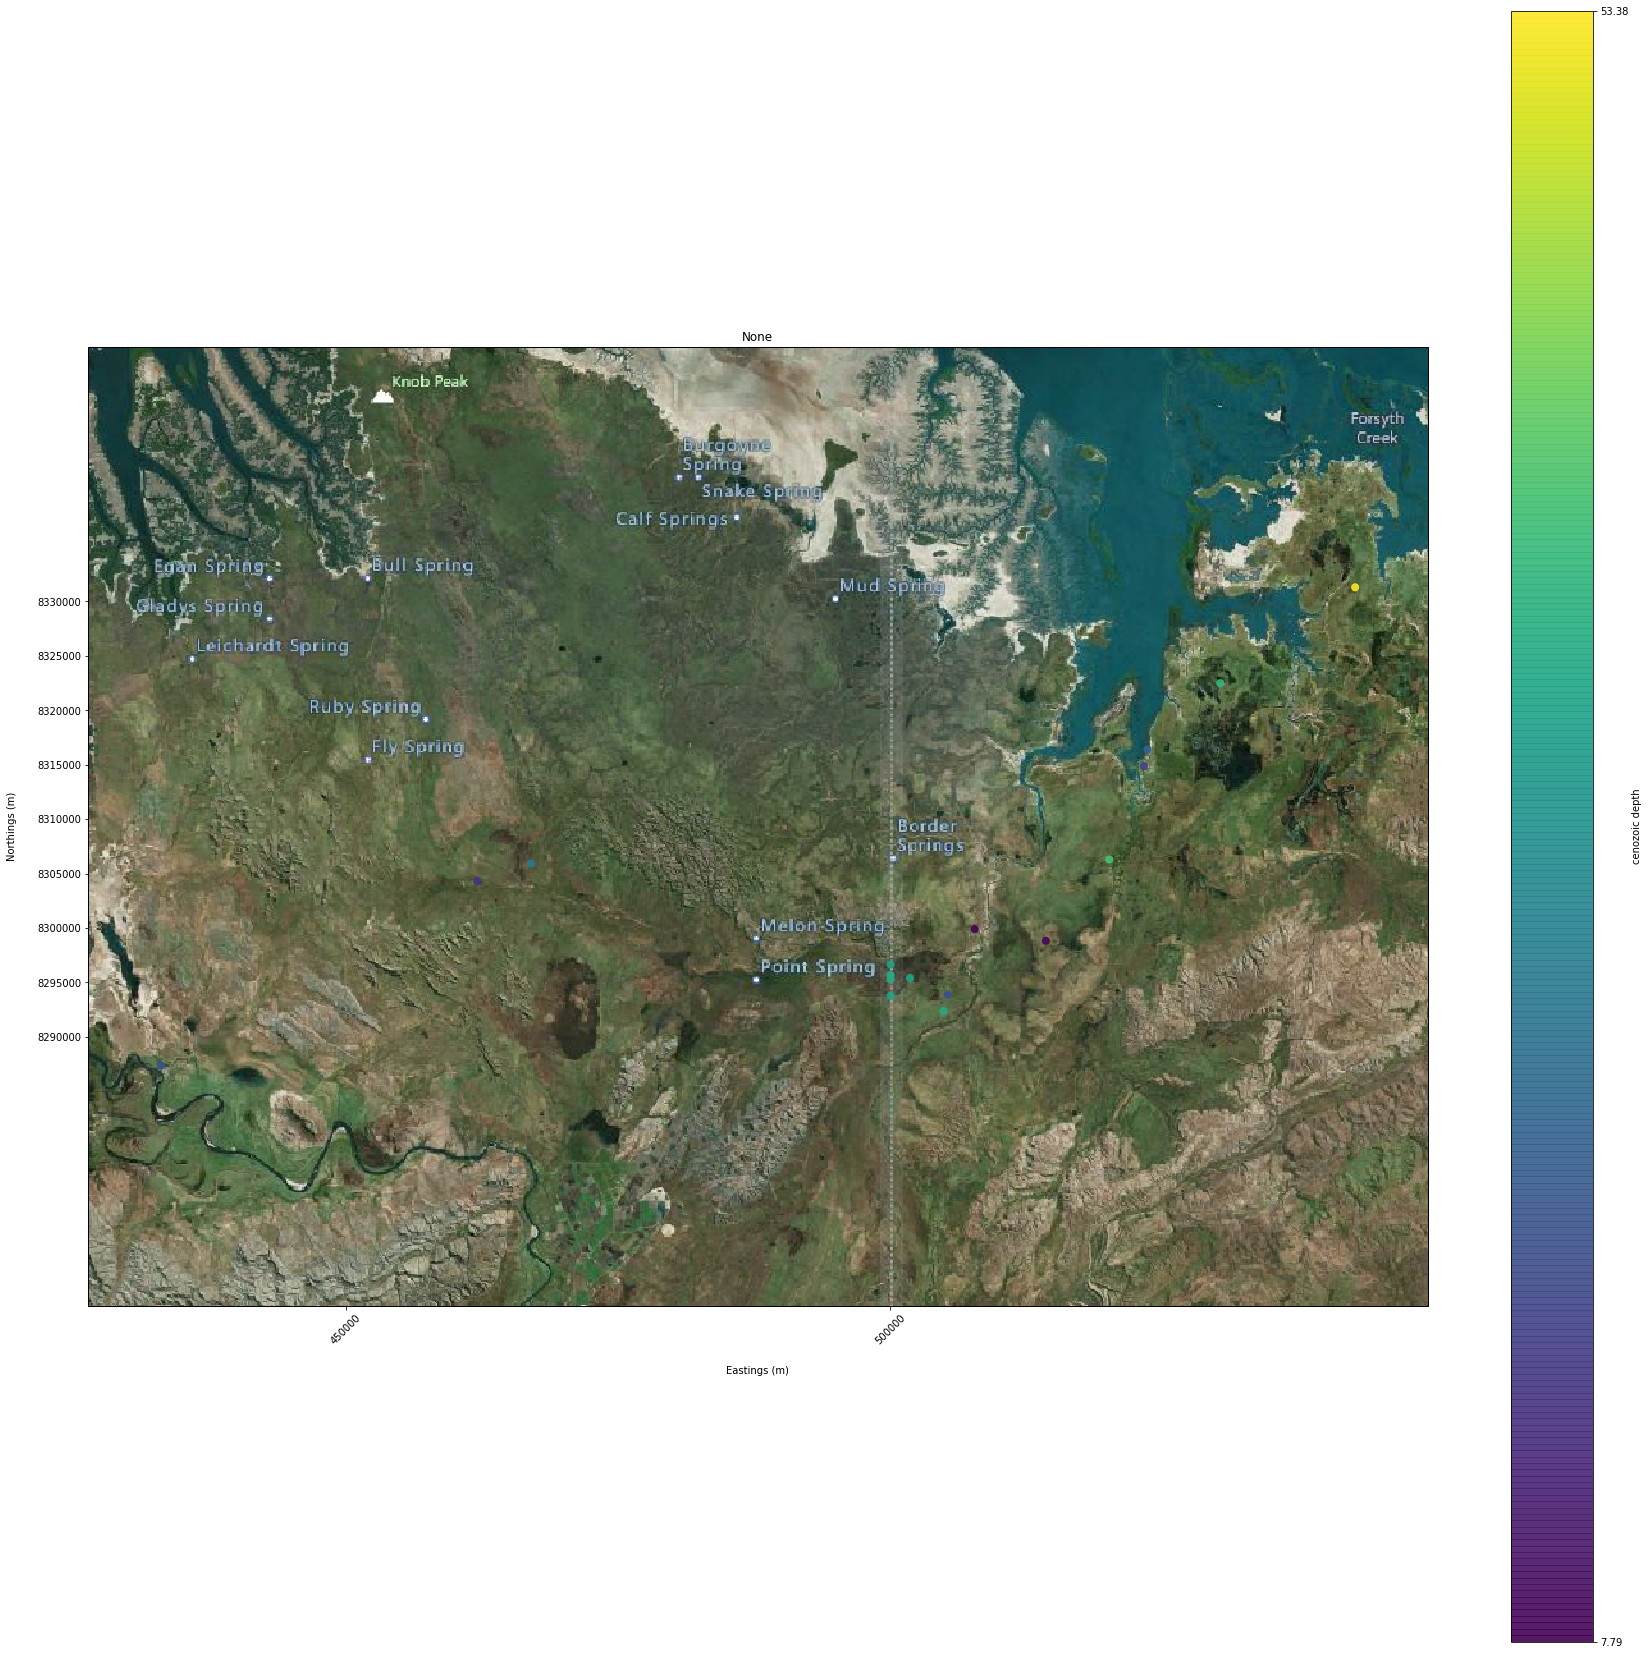

In [21]:
# Plot the bores on a basemap to get an idea of what datasets are available

utm_coords = df_interp[['Easting', 'Northing']].values

# For example do we have javelin available
depth = df_interp['base_of_cenozoic_depth'].values

plotting_utils.plot_point_dataset(utm_coords, "EPSG:28352", depth,
                   colourbar_label = 'cenozoic depth', colour_scheme = 'viridis',
                    point_size=50)


In [22]:
# First import all the datasets based on our enos (primary key)


df_bNMR = borehole_utils.extract_sql_with_primary_key("boreholeNMR_data", ['Depth', 'Total_water_content',
                                                'Clay_water_content', 'Capillary_water_content',
                                               'Free_water_content', 'K_SDR', 'borehole_id'], connection, enos,
                                                verbose = True)

df_lithology = borehole_utils.extract_sql_with_primary_key("borehole_lithology", ['Depth_from', 'Depth_to',
                                                'Lithology_name', 'Munsell_colour',
                                                           'borehole_id'], connection, enos,
                                                          verbose = True)


# Classify the lithology using a yaml file keyword lookup table
yaml_file = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\classification\hydclass_classification.yml"

with open(yaml_file) as f:
    # use safe_load instead load
    hyd_class = yaml.safe_load(f)


# Assign all rows to a class of 7 which is the unkown class
df_lithology['hydraulic_class'] = 7

# iterate through lithology names
for index, row in df_lithology.iterrows():
    lithname = row.Lithology_name
    
    # Add the classification integer to the dataframe if it is found
    interval_class = search(hyd_class, lithname)
    
    if interval_class is not None:
        df_lithology.at[index, 'hydraulic_class'] = interval_class
    else:
        # Otherwise we can add it to the yaml file
        print(lithname)
    
    

df_indgam = borehole_utils.extract_sql_with_primary_key("induction_gamma_data", 
                                                        ['Depth', 'Apparent_conductivity','Gamma_calibrated',
                                                         'GR','borehole_id'], connection, enos,
                                                       verbose = True)

df_EC_pH = borehole_utils.extract_sql_with_primary_key("pore_fluid_EC_pH", 
                                                       ['Depth', 'EC', 'pH', 'borehole_id'],
                                                       connection, enos, verbose = True)

df_AEM = borehole_utils.extract_sql_with_primary_key("representative_AEM_bulk_conductivity", 
                                                       ['Depth_from', 'Depth_to', 'Bulk_conductivity', 'borehole_id'],
                                                       connection, enos, verbose = True)

df_magsus = borehole_utils.extract_sql_with_primary_key("magnetic_susceptibility", 
                                                       ['Depth', 'Magnetic_susceptibility', 'borehole_id'],
                                                       connection, enos, verbose = True)

select t.Depth, t.Total_water_content, t.Clay_water_content, t.Capillary_water_content, t.Free_water_content, t.K_SDR, t.borehole_id from boreholeNMR_data t where t.borehole_id in (635728,635921,635730,635733,635734,635735,635737,635738,635739,635740,635741,635742,635744,635747,635748,635749,635746);
select t.Depth_from, t.Depth_to, t.Lithology_name, t.Munsell_colour, t.borehole_id from borehole_lithology t where t.borehole_id in (635728,635921,635730,635733,635734,635735,635737,635738,635739,635740,635741,635742,635744,635747,635748,635749,635746);
select t.Depth, t.Apparent_conductivity, t.Gamma_calibrated, t.GR, t.borehole_id from induction_gamma_data t where t.borehole_id in (635728,635921,635730,635733,635734,635735,635737,635738,635739,635740,635741,635742,635744,635747,635748,635749,635746);
select t.Depth, t.EC, t.pH, t.borehole_id from pore_fluid_EC_pH t where t.borehole_id in (635728,635921,635730,635733,635734,635735,635737,635738,635739,635740,635741,635742,635744,635747,63

In [23]:
# Define our columns of interest for the hylogging data

columns = ["Quartz_(U_TIR_TSA707_Mineral)",
          "Kaolinite-PX_(U_SWIR_TSA705_Mineral)",
          "Kaolinite-WX_(U_SWIR_TSA705_Mineral)",
          "Kaolinite-PX_(U_TIR_TSA707_Mineral)",
          "Kaolinite-WX_(U_TIR_TSA707_Mineral)",
          "Calcite_(U_SWIR_TSA705_Mineral)",
          "Montmorillonite_(U_TIR_TSA707_Mineral)",
          "Montmorillonite_(U_SWIR_TSA705_Mineral)",
           "Depth", "borehole_id"
          ]

In [24]:
# Import the hylogging data

infile = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\hylogger\EK_hylogg_results_chips.csv"

df_chips = pd.read_csv(infile)[columns]

infile = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\hylogger\EK_hylogg_results_core.csv"

df_core = pd.read_csv(infile)[columns]


C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (14,66) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [25]:
# Stack the data

df_hylog = df_chips.append(df_core)

In [26]:
# Now for the important datasets lets assign them as either cenozoic, basement
# or a mixture

df_hylog['stratigraphy'] = ''
df_AEM['stratigraphy'] = ''
df_bNMR['stratigraphy'] = ''
df_indgam['stratigraphy'] = ''

for index, row in df_interp.iterrows():
    borehole = int(row['borehole_id'])
    
    depth = row['base_of_cenozoic_depth']
    
    # AEM
    
    mask = df_AEM['borehole_id'] == borehole
    
    df_AEM_ = assign_stratigraphy_from_depth(df_AEM[mask], depth, ['Depth_from', 'Depth_to'])
    
    df_AEM.at[df_AEM[mask].index, 'stratigraphy'] = df_AEM_
    
    # Hylog
    mask = df_hylog['borehole_id'] == borehole
    
    df_hylog_ = assign_stratigraphy_from_depth(df_hylog[mask], depth, ['Depth'])
    
    df_hylog.at[df_hylog[mask].index, 'stratigraphy'] = df_hylog_
    
    # bNMR
    mask = df_bNMR['borehole_id'] == borehole
    
    df_bNMR_ = assign_stratigraphy_from_depth(df_bNMR[mask], depth, ['Depth'])
    
    df_bNMR.at[df_bNMR[mask].index, 'stratigraphy'] = df_bNMR_
    
    # induction
    mask = df_indgam['borehole_id'] == borehole
    
    df_indgam_ = assign_stratigraphy_from_depth(df_indgam[mask], depth, ['Depth'])
    
    df_indgam.at[df_indgam[mask].index, 'stratigraphy'] = df_indgam_

df_hylog_shallow = df_hylog[df_hylog['Depth'] < 60.]
df_AEM_shallow = df_AEM[df_AEM['Depth_from'] < 60.]
df_bNMR_shallow = df_bNMR[df_bNMR['Depth'] < 60.]
df_indgam_shallow = df_indgam[df_indgam['Depth'] < 60.]

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [146]:
df_indgam_shallow.columns

Index(['Depth', 'Apparent_conductivity', 'Gamma_calibrated', 'GR',
       'borehole_id', 'stratigraphy'],
      dtype='object')

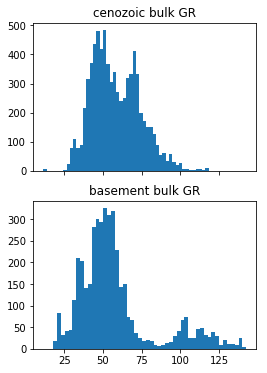

In [148]:
# Create a sub plot with the various histograms

fig, (ax1,ax2) = plt.subplots(2,1, figsize = (4,6), sharex = True)

masks =  ['cenozoic', 'mixed_signal', 'basement']

col = 'GR'

# Assign row and column for the subpots

ax1.hist(df_indgam_shallow[df_indgam_shallow['stratigraphy'] == masks[0]][col].dropna().values,
         bins = 50)
ax2.hist(df_indgam_shallow[df_indgam_shallow['stratigraphy'] == masks[2]][col].dropna().values,
         bins = 50)
ax1.set_title('cenozoic bulk ' + col)
ax2.set_title('basement bulk ' + col)

outdir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\base_of_ceno\indgam_variables"

if not os.path.exists(outdir):
    os.mkdir(outdir)

plt.savefig(os.path.join(outdir, col + "_histogram.png"))
plt.show()

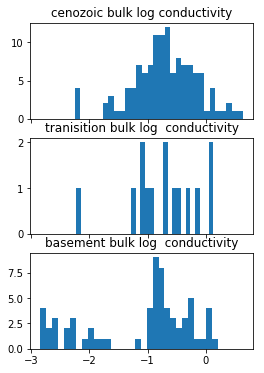

In [29]:
# Create a sub plot with the various histograms

fig, (ax1,ax2, ax3) = plt.subplots(3,1, figsize = (4,6), sharex = True)

masks =  ['cenozoic', 'mixed_signal', 'basement']

# Assign row and column for the subpots

ax1.hist(np.log10(df_AEM_shallow[df_AEM_shallow['stratigraphy'] == masks[0]]['Bulk_conductivity'].values),
         bins = 30)
ax2.hist(np.log10(df_AEM_shallow[df_AEM_shallow['stratigraphy'] == masks[1]]['Bulk_conductivity'].values),
         bins = 30)
ax3.hist(np.log10(df_AEM_shallow[df_AEM_shallow['stratigraphy'] == masks[2]]['Bulk_conductivity'].values),
         bins = 30)
ax1.set_title('cenozoic bulk log conductivity')
ax2.set_title('tranisition bulk log  conductivity')
ax3.set_title('basement bulk log  conductivity')

outdir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\base_of_ceno\AEM_variables"

if not os.path.exists(outdir):
    os.mkdir(outdir)

plt.savefig(os.path.join(outdir, "bulk_conductivity_histogram.png"))

plt.show()

In [32]:
# Run the Ks-test for similarity

from scipy.stats import ks_2samp

# Extract log hydraulic K for each unit
nmr_ceno = df_bNMR_shallow[df_bNMR_shallow['stratigraphy'] == masks[0]]['Clay_water_content'].values
nmr_basement = df_bNMR_shallow[df_bNMR_shallow['stratigraphy'] == masks[2]]['Clay_water_content'].values

ks_2samp(nmr_ceno, nmr_basement)



Ks_2sampResult(statistic=0.14816034410903645, pvalue=2.2771457387360508e-06)

In [27]:
df_bNMR_shallow

,Depth,Total_water_content,Clay_water_content,Capillary_water_content,Free_water_content,K_sdr,borehole_id,stratigraphy
0,40.7600,0.211534,0.000000,0.054079,0.157455,None,635728,basement
1,40.2600,0.212585,0.000000,0.035272,0.177313,None,635728,basement
2,39.7600,0.271154,0.015436,0.065424,0.190294,None,635728,cenozoic
3,39.2600,0.215071,0.011638,0.097797,0.105637,None,635728,cenozoic
4,38.7600,0.209562,0.006646,0.068862,0.134054,None,635728,cenozoic
5,38.2600,0.232290,0.000835,0.061644,0.169811,None,635728,cenozoic
6,37.7600,0.280664,0.028475,0.101272,0.150918,None,635728,cenozoic
7,37.2600,0.353717,0.101956,0.106088,0.145673,None,635728,cenozoic
8,36.7600,0.454232,0.168902,0.142937,0.142393,None,635728,cenozoic
9,36.2600,0.523378,0.198190,0.178649,0.146539,None,635728,cenozoic
